这个notebook是对omarelgabry的[kernel](https://www.kaggle.com/omarelgabry/a-journey-through-titanic)的学习。其数据可视化和特征处理的思路可以参考，但感觉并不是那么有用。

最后结果看起来有97%的精度，但我觉得这个结果过于夸张，他选用的测试数据和训练数据一样才会有这么高的精度，原kernel下面有很多人也在评论中质疑了这一点。我这里使用交叉验证得到的结果也就一般般。

不管怎样，作为学习，看看也无妨。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

%matplotlib inline

## Read Data

In [2]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()
print('----------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare      

去掉无用的列

In [4]:
train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
test_df.drop(['Name', 'Ticket'], axis=1, inplace=True)

## Embarked分析

Port of Embarkation

- C = Cherbourg
- Q = Queenstown
- S = Southampton

查看NaN值，把它们填充为‘S'（出现次数最多）

In [5]:
print('Embarked value counts:', train_df['Embarked'].value_counts(), sep='\r\n')

display(train_df[train_df.isnull()["Embarked"]])

train_df['Embarked'].fillna('S', inplace=True)

print('Embarked value counts:', train_df['Embarked'].value_counts(), sep='\r\n')

Embarked value counts:
S    644
C    168
Q     77
Name: Embarked, dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1,1,female,38.0,0,0,80.0,B28,NaN
829,1,1,female,62.0,0,0,80.0,B28,NaN


Embarked value counts:
S    646
C    168
Q     77
Name: Embarked, dtype: int64


绘图，对Embarked有个直观的认识

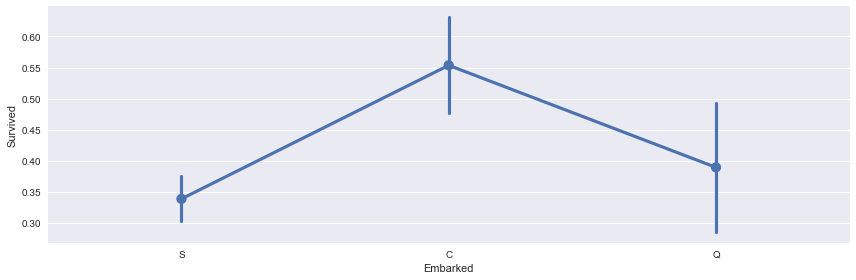

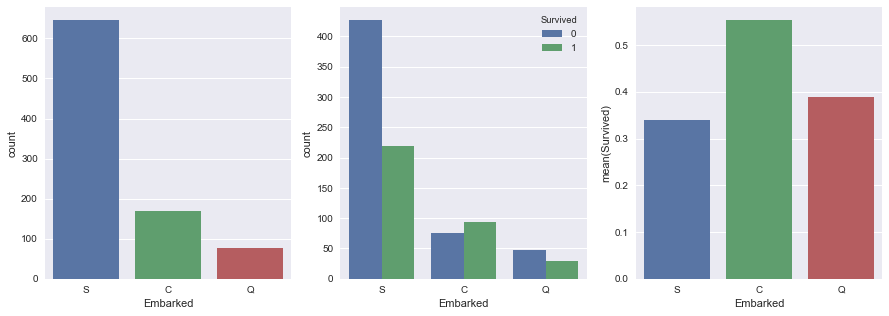

In [6]:
sns.factorplot('Embarked', 'Survived', data=train_df, size=4, aspect=3)

# 统计，绘图。通过countplot可以直接实现
# embarked_df = train_df.groupby(['Embarked', 'Survived']).size().reset_index(name='Count')
# sns.barplot(x='Embarked', y='Count', hue='Survived', data=embarked_df, ax=ax2, order=['S', 'C', 'Q'])

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.countplot(x='Embarked',  data=train_df, ax=ax1)
sns.countplot(x='Embarked', hue='Survived', data=train_df, ax=ax2)

embarked_per = train_df[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embarked_per, order=['S', 'C', 'Q'], ax=ax3)

plt.show()

对特征Embarked进行处理

In [7]:
embark_dummies = pd.get_dummies(train_df['Embarked'])
embark_dummies.drop('S', axis=1, inplace=True)

train_df = train_df.join(embark_dummies)
train_df.drop(['Embarked'], axis=1, inplace=True)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q
0,0,3,male,22.0,1,0,7.2500,NaN,0,0
1,1,1,female,38.0,1,0,71.2833,C85,1,0
2,1,3,female,26.0,0,0,7.9250,NaN,0,0
3,1,1,female,35.0,1,0,53.1000,C123,0,0
4,0,3,male,35.0,0,0,8.0500,NaN,0,0


## Fare

票价。可以看出测试集中没有NaN

In [8]:
train_df.isnull()['Fare'].value_counts()

False    891
Name: Fare, dtype: int64

对Fare特征唯一的处理就是将它的值转化为整数。其余的工作都是为了对这个特征有个直观的认识。

看一下Fare的分布，可以发现票价集中在相对便宜的区域。

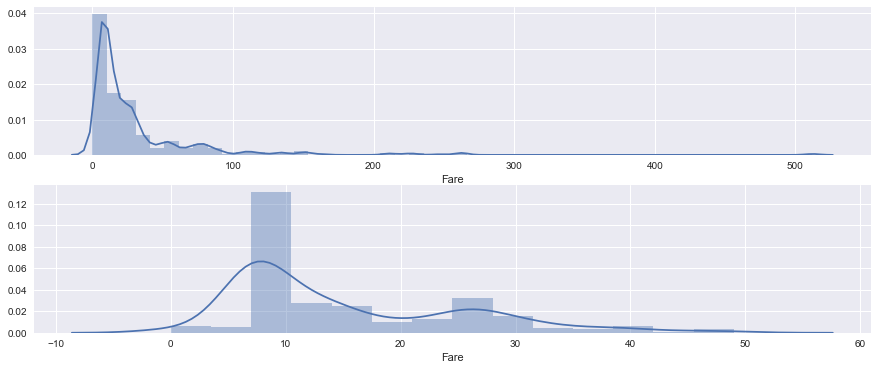

In [9]:
train_df['Fare'] = train_df['Fare'].astype(int)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
sns.distplot(train_df.loc[:, 'Fare'], ax=ax1)
sns.distplot(train_df.loc[train_df['Fare']<50, 'Fare'], ax=ax2)
plt.show()

详细地，我们对票价分档

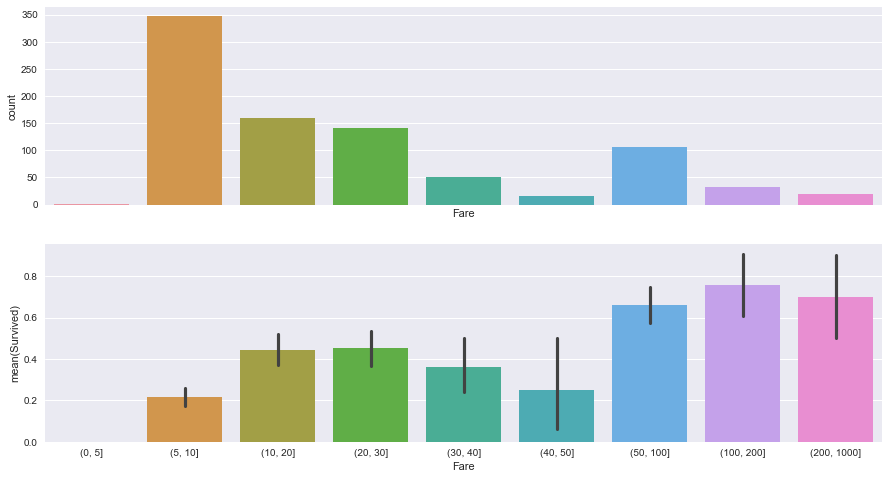

In [10]:
fare_section = pd.cut(train_df['Fare'], [0, 5, 10, 20, 30, 40, 50, 100, 200, 1000])

# 每档的数量
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)
ax = sns.countplot(fare_section, ax=ax1)

# 每档的存活率
ax = sns.barplot(fare_section, train_df["Survived"], ax=ax2)

换个角度，我们分别统计存活与否时的平均值。可以明显看到，存活下来的票价均值明显高于不能存活下来的票价均值。

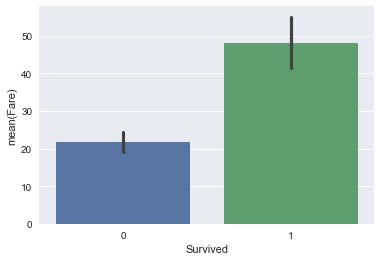

In [11]:
ax = sns.barplot(x='Survived', y='Fare', data=train_df)

## Age

首先，检查NaN值，可以发现NaN值还是挺多的。

In [12]:
train_df['Age'].isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

可以尝试在均值±标准差的范围内随机填充这些NaN值

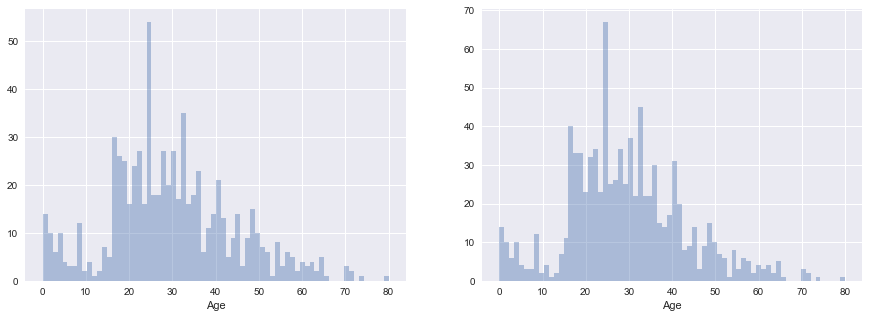

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax = sns.distplot(train_df['Age'].dropna().astype(int), bins=70, kde=False, ax=ax1)

age_mean = train_df['Age'].mean()
age_std = train_df['Age'].std()

# 随机填充
age_random = np.random.randint(age_mean - age_std, age_mean + age_std, train_df['Age'].isnull().sum())
train_df.loc[train_df['Age'].isnull(), 'Age'] = age_random
train_df['Age'] = train_df['Age'].astype(int)

ax = sns.distplot(train_df['Age'], bins=70, kde=False, ax=ax2)

继续绘制未存活的年龄分布、存活的年龄分布，和各年龄的存活率。

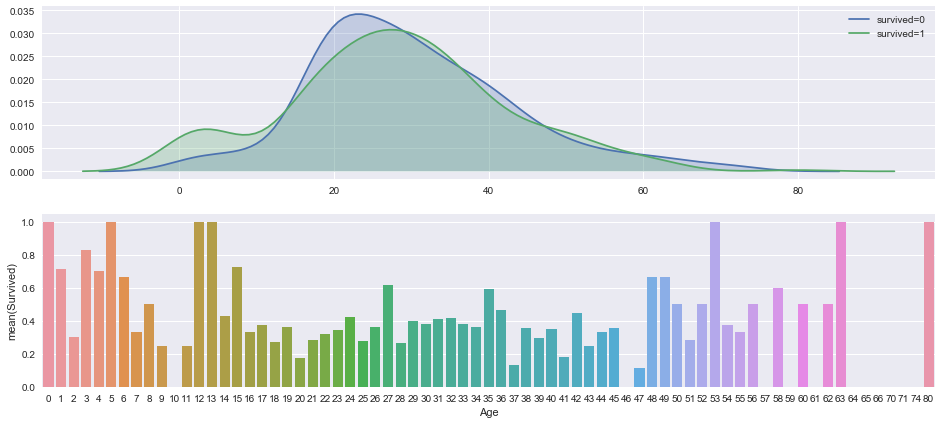

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 7))
ax = sns.kdeplot(train_df.loc[train_df['Survived']==0, 'Age'], shade=True, ax=ax1, label='survived=0')
ax = sns.kdeplot(train_df.loc[train_df['Survived']==1, 'Age'], shade=True, ax=ax1, label='survived=1')

ax = sns.barplot('Age', 'Survived', data=train_df, ci=None)

## Cabin

由于NaN值太多，直接丢弃掉。

In [15]:
print(train_df['Cabin'].isnull().value_counts())

train_df.drop('Cabin', axis=1, inplace=True)

True     687
False    204
Name: Cabin, dtype: int64


## Family

考察Parch和SibSp特征：
- Sibsp: of siblings / spouses aboard the Titanic	
- Parch: of parents / children aboard the Titanic

将这两个特征合并成一个特征“Family”，并二值化，表示每个乘客是否有家人在船上。

In [16]:
train_df['Family'] = train_df['Parch'] + train_df['SibSp']
train_df.loc[train_df['Family'] > 0, 'Family'] = 1

train_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,C,Q,Family
0,0,3,male,22,7,0,0,1
1,1,1,female,38,71,1,0,1
2,1,3,female,26,7,0,0,0
3,1,1,female,35,53,0,0,1
4,0,3,male,35,8,0,0,0


查看有没有家人对存活率的影响：

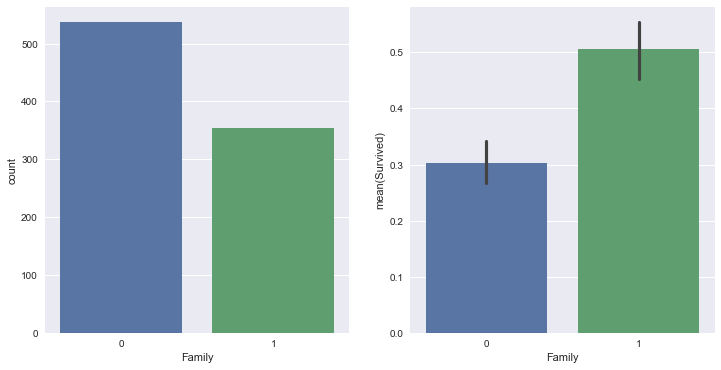

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 没有家人、有家人 总数
ax = sns.countplot('Family', data=train_df, ax=ax1)
# 没有家人、有家人 存活率
ax = sns.barplot('Family', 'Survived', data=train_df, ax=ax2)

## Sex

- 将Sex特征转为Perseon特征，Person特征除了male、female以外还增加了child。
- 将Person中的female、child单独拎出来作为单独的特征
- 抛弃Sex、Person

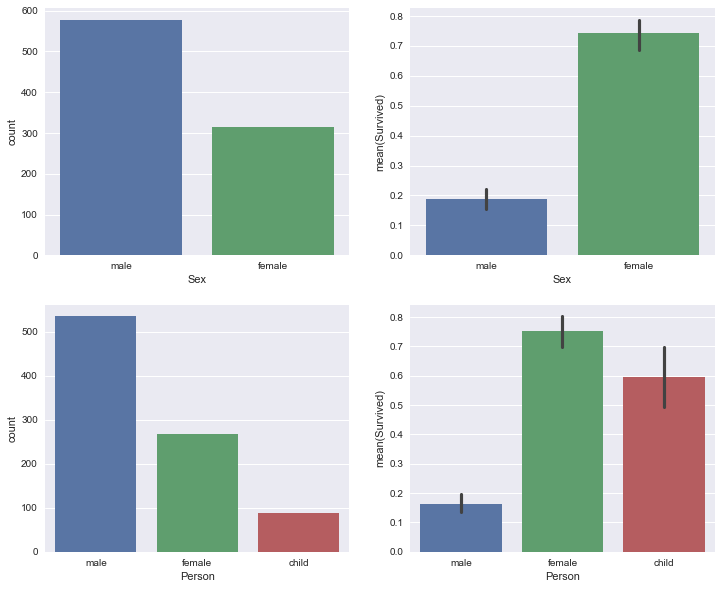

In [18]:
train_df['Person'] = train_df.apply(lambda x: 'child' if x['Age'] < 16 else x['Sex'], axis=1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ax = sns.countplot('Sex', data=train_df, ax=axs[0][0])
ax = sns.barplot('Sex', 'Survived', data=train_df, ax=axs[0][1])
ax = sns.countplot('Person', data=train_df, ax=axs[1][0])
ax = sns.barplot('Person', 'Survived', data=train_df, ax=axs[1][1])

In [19]:
train_df = train_df.join(pd.get_dummies(train_df['Person']))
train_df.drop('male', axis=1, inplace=True)
train_df.rename(columns={'child': 'Child', 'female': 'Female'}, inplace=True)

train_df.drop(['Sex', 'Person'], axis=1, inplace=True)

train_df.head()

,Survived,Pclass,Age,Fare,C,Q,Family,Child,Female
0,0,3,22,7,0,0,1,0,0
1,1,1,38,71,1,0,1,0,1
2,1,3,26,7,0,0,0,0,1
3,1,1,35,53,0,0,1,0,1
4,0,3,35,8,0,0,0,0,0


## Pclass

Pclass:	Ticket class

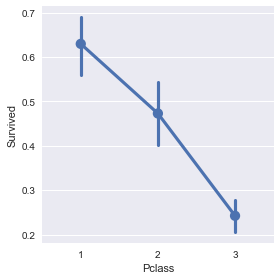

In [20]:
ax = sns.factorplot('Pclass', 'Survived', data=train_df, size=4)

将Pclass特征拆分成Class_1、Class_2、Class_3，并丢弃存活率最低的Class_3和原始的Pclass。

In [21]:
train_df = train_df.join(pd.get_dummies(train_df['Pclass']))
train_df.rename(columns={1: 'Class_1', 2: 'Class_2', 3: 'Class_3'}, inplace=True)

train_df.drop(['Pclass', 'Class_3'], axis=1, inplace=True)

train_df.head()

,Survived,Age,Fare,C,Q,Family,Child,Female,Class_1,Class_2
0,0,22,7,0,0,1,0,0,0,0
1,1,38,71,1,0,1,0,1,1,0
2,1,26,7,0,0,0,0,1,0,0
3,1,35,53,0,0,1,0,1,1,0
4,0,35,8,0,0,0,0,0,0,0


## Train and Test

构建X、y

In [22]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

利用逻辑回归进行交叉验证。精度为80%左右。

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

logistic = LogisticRegression(C=10)
score = cross_val_score(logistic, X, y, cv=3)
score

array([ 0.7979798 ,  0.79461279,  0.81144781])

omarelgabry的测试方法，直接利用全部数据。精度也为80%左右。

In [24]:
logistic = LogisticRegression(C=10)
logistic.fit(X, y)
logistic.score(X, y)

0.81144781144781142

利用随机森林进行交叉验证。精度约为78%。

In [25]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)

score = cross_val_score(random_forest, X, y, cv=3)
score

array([ 0.79124579,  0.78787879,  0.79124579])

omarelgabry的测试方法，直接利用全部数据。精度接近97%，但上面的交叉验证表现却不好，这里我个人怀疑omarelgabry的方法有过拟合问题。

In [26]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X, y)

random_forest.score(X, y)

0.96520763187429859